# Predicting house sale prices with linear regression

<p align='center'>    
    <img src="imgs/house-sale-sign.jpg" width=500 height=350 />
</p>    

<p style="text-align: center;">(comic by Clay Bennet: https://twitter.com/BennettCartoons])</p>

## Introduction

When you want to sell your house, how do you come up with a price? And which features of the house are important to take into account?<br/>
Usually these and other questions are answered with the help of a real estate professional, who "knows" what is important and why. But what if we try to answer with the help of machine learning and build our own model for predicting a house sale price?

In this project, we're going to use **a dataset describing the sale of properties in Ames, Iowa**, between 2006 and 2010.<br/> 
Each sale is described through a large number of categorical and numerical quantities.

**<u>Credits and references</u>**:<br/>
The dataset was found, cleaned and brought to attention by Dean De Cock, professor of statistics at Truman State University. The motivation for its introduction can be found in [this article](https://www.tandfonline.com/doi/pdf/10.1080/10691898.2011.11889627?needAccess=true).<br/>
The precise description of each house feature can be found [here](https://s3.amazonaws.com/dq-content/307/data_description.txt).

## Project's goal and outline

The **goal** is to find a **multivariate linear model** which can predict the house sale price significantly better than the best-performing univariate linear models.<br/>


In order to do so, several steps have to be taken, among which the main are: 
- cleaning the dataset (e.g. dealing with missing values, remove outliers); 
- doing some feature engineering to transform the features in a format the algorithm can handle; 
- selecting a subset of highly predictive features.<br/>

For this last step, we're going to use one-way ANOVA test to highlight the categorical features which are most strongly associated with sale price, while for numerical features we're going to use Pearson's r correlation.<br/>
We'll also be careful to drop the numerical features with very low variance and to try to avoid self-correlation.

A pipeline will be in place, so that, potentially, different parameters and criteria could be used to select the best model.

### Summary of results

Very briefly, we reached our goal by selecting 16 numerical and 11 categorical features, managing to predict the house sale price with an average error of 19600 USD, much better than the 46000 USD of the best univariate model.

### Modules, libraries and project-wide settings

In [1]:
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import os
import pandas as pd
import scipy.stats as stats
import seaborn as sns

# ML functionalities
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# plot settings
plt.style.use('seaborn-darkgrid')  # pyplot style
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=14)          # controls default text sizes

# notebook display settings
pd.options.display.max_rows = 50

## Getting to know the dataset

In [2]:
# read in the dataset
path = os.path.join(os.curdir, 'datasets', 'AmesHousing.txt')
df = pd.read_csv(path, delimiter='\t')

df.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [3]:
print(df.shape)

(2930, 82)


The intial dataframe contains 2930 examples and 82 features.

Our target is the house sale price, i.e. the `SalePrice` column. Let's take a look at its distribution:

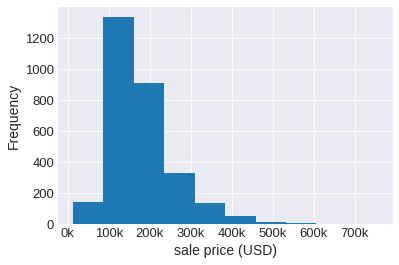

count      2930.000000
mean     180796.060068
std       79886.692357
min       12789.000000
25%      129500.000000
50%      160000.000000
75%      213500.000000
max      755000.000000
Name: SalePrice, dtype: float64


In [4]:
df['SalePrice'].plot.hist()
plt.xlabel('sale price (USD)')
plt.xticks(range(0, 800000, 100000), labels=[str(n) + 'k' for n in range(0, 800, 100)])
plt.show()
# summary statistics
print(df['SalePrice'].describe())

Most prices are comprised between 120000 and 250000 USD, and the whole range of values seems reasonable.

Let's see how the data types are distributed:

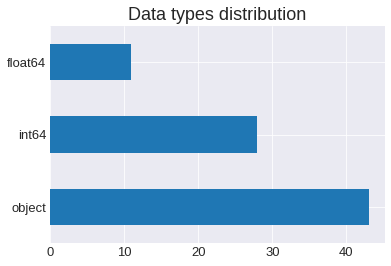

In [5]:
df.dtypes.value_counts().plot.barh()
plt.title('Data types distribution')
plt.show()

We see that 43 columns are encoded as objects and are probably categorical, while 39 are purely numerical.<br/>
Actually, we must be careful because this doesn't necessarily means all 43 are categorical and all 39 are actually numerical. That's just how they are encoded, and we must read the docs to really understand.

Let's use the `missingno` module for a bird's eye view of missing values:

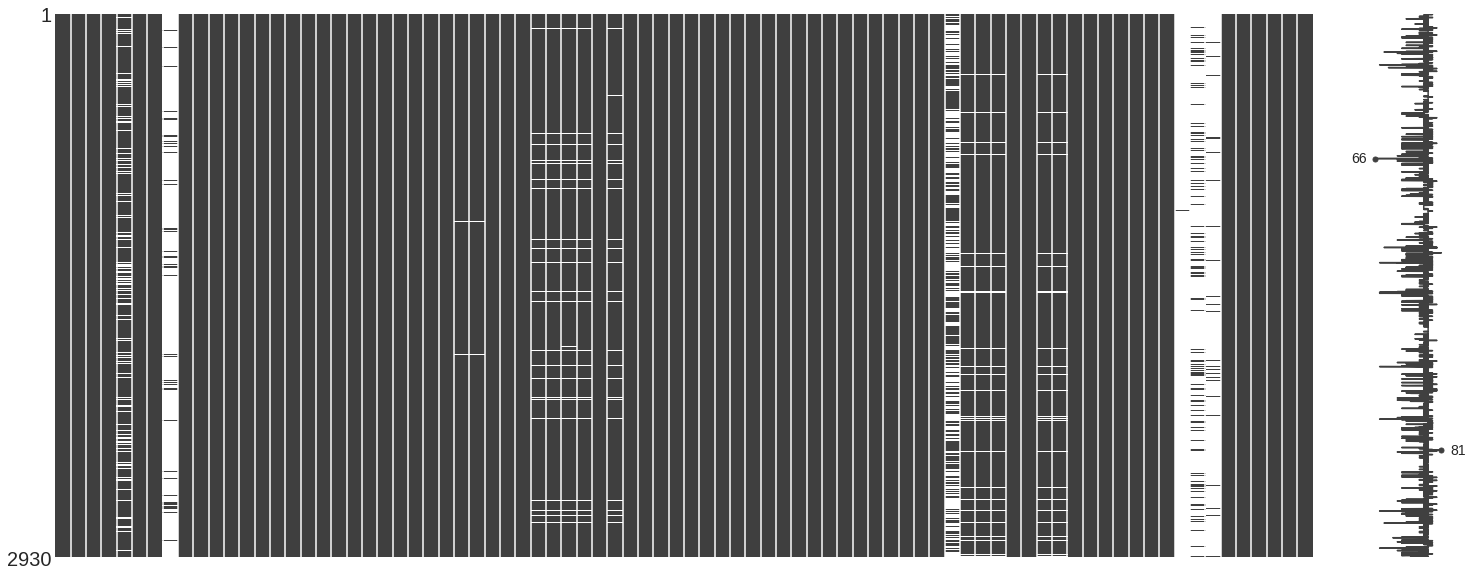

In [6]:
msno.matrix(df)
plt.show()

Most columns (grey) are complete, some others have a varying fraction of missing values (in white).

In [7]:
# which columns have missing values
df.columns[df.isnull().sum() > 0]

Index(['Lot Frontage', 'Alley', 'Mas Vnr Type', 'Mas Vnr Area', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Electrical', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Fireplace Qu',
       'Garage Type', 'Garage Yr Blt', 'Garage Finish', 'Garage Cars',
       'Garage Area', 'Garage Qual', 'Garage Cond', 'Pool QC', 'Fence',
       'Misc Feature'],
      dtype='object')

Some of these columns are categorical, other numerical.<br/> 

By carefully reading the documentation, we have discovered that, for categorical columns, **`Nan` doesn't correspond to a missing value, but to the lack of a certain feature** (e.g. a nan for `Alley` means no alley access). These information are really important as we will drop columns based on the percentage of missing values.

Another important fact is that the following columns are actually **categorical, but encoded with numbers**:

`MS SubClass`, `Overall Qual`, `Overall Cond`

They must be properly converted so to include them in the categorical feature analysis.<br/>

As a last step in exploratory analysis, let's consider some numerical columns and draw their boxplot:

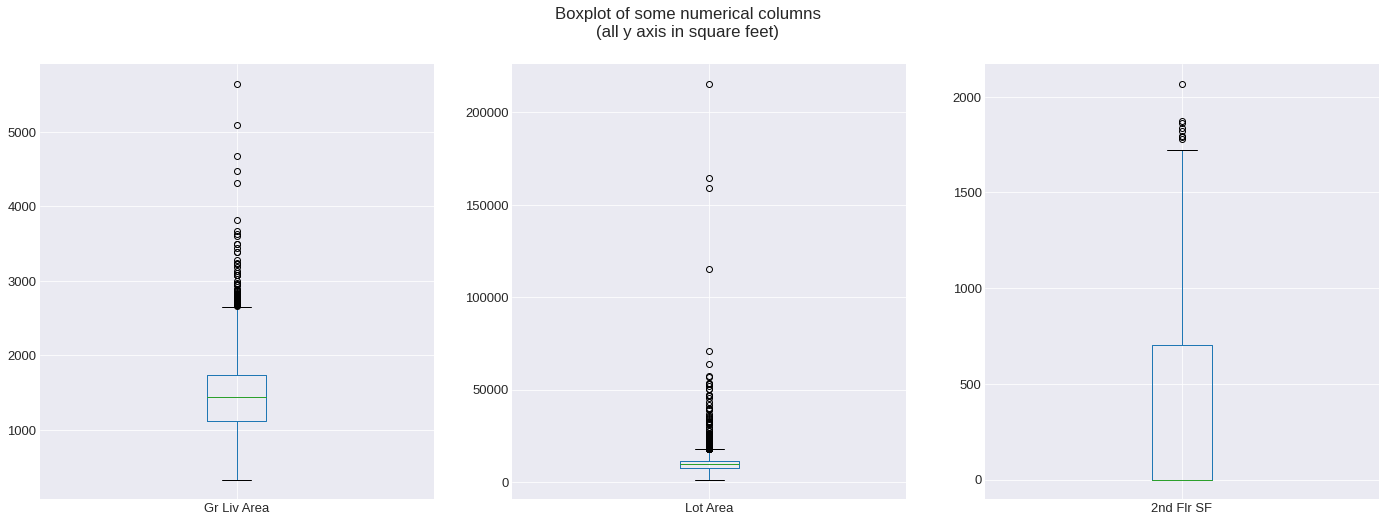

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(24, 8))

sample_num_cols = ['Gr Liv Area', 'Lot Area', '2nd Flr SF']
for i, ax in enumerate(fig.get_axes()):
    df[sample_num_cols[i]].plot.box(ax=ax)
    
fig.suptitle('Boxplot of some numerical columns\n(all y axis in square feet)')    

plt.show()    

As we see, outliers are present. These are defined by default by pandas as all values which are more than 1.5 interquartile ranges from the mean.

We will sort this and other issues in the feature engineering section.<br/>

## Selecting categorical features before encoding them

Before we transform the features in a proper format for the regression algorithm, we need to understand which categorical columns we want to keep. We have to do it before we encode them because, after numerical encoding, each variable is split into several independent columns, making the analysis process much more difficult.

In [9]:
# as first step, convert cat. columns encoded as numerical
numerical_vars_to_convert = ['MS SubClass', 'Overall Qual', 'Overall Cond']
for col in numerical_vars_to_convert:
    # use 'str' instead of 'object' to avoid Python treat them as numbers 
    df[col] = df[col].astype('str')   

The following is a function which returns a dataframe containing **a statistical report about all categorical columns**; based on those results, we will determine which columns will be part of the model.

The function also performs a **one-way ANOVA test** between each cat. variable and the specified target column (in our case, `SalePrice`). This is done to help us recognize which columns may be strongly associated with the sale price.

In [10]:
def report_cat_vars(raw_data: pd.DataFrame, target: str) -> pd.DataFrame:
    '''
    Calculate some basics statistics to help select the most significant categorical
    features of the dataset. In particular, it also performs a one-way ANOVA test to
    measure association of each feature with the target (numerical column).
    
    Parameters:
    -----------
        - raw_data: dataframe containing all features, with categorical encoded as 'object'.
                  Nans can be present, but will be encoded as 'not_present' (i.e. feature not present).
                  Therefore, beware of the meaning of nan in your dataset.
        - target: target feature in the regression problem.
        
    Return:
    -------
        A dataframe containing the statistics of all categorical variables.
    '''   
        
    data = raw_data.copy()
       
    # report dictionary to be returned as a dataframe
    report = {'cat_var': [],
              'no_of_cats': [],
              'most_repr_cat (%)': [],
              'f_value': [],
              'p_value (%)': []}
             
    for col in data.columns:
        if data[col].dtypes == 'O':
            data[col] = data[col].fillna('not_present')
            report['cat_var'].append(col)
            report['no_of_cats'].append(len(data[col].unique()))
            pct_most_repr_cat = data[col].value_counts().max() / len(data[col]) * 100
            report['most_repr_cat (%)'].append(round(pct_most_repr_cat, 1))
            # perform one-way ANOVA test to measure association between the
            # current cat.variable and target (continuous) variable
            grouped_prices = []
            categories = data[col].unique()
            for category in categories:
                grouped_prices.append(data[data[col] == category][target])            
            f_value, p_value = stats.f_oneway(*grouped_prices)
            report['f_value'].append(round(f_value, 1))
            report['p_value (%)'].append(round(p_value * 100, 3))
            
    print(f'The dataframe contains \033[1m{len(report["cat_var"])} categorical columns\033[0m.\n')        
            
    return pd.DataFrame(report).set_index('cat_var')

In [11]:
# print the report
report_cat_df = report_cat_vars(df, 'SalePrice')
print(report_cat_df.sort_values(['no_of_cats'], ascending=False))

The dataframe contains 46 categorical columns.

                no_of_cats  most_repr_cat (%)  f_value  p_value (%)
cat_var                                                            
Neighborhood            28               15.1    144.4        0.000
Exterior 2nd            17               34.6     37.1        0.000
MS SubClass             16               36.8     64.0        0.000
Exterior 1st            16               35.0     39.7        0.000
Overall Qual            10               28.2    765.2        0.000
Sale Type               10               86.6     52.7        0.000
Condition 1              9               86.1     17.3        0.000
Overall Cond             9               56.5     64.6        0.000
Roof Matl                8               98.5      6.8        0.000
Functional               8               93.1      7.5        0.000
Condition 2              8               99.0     10.4        0.000
House Style              8               50.5     35.0        0.000


We now have to decide which columns to drop. First of all, we'll use the following criteria:

1. **More than 95% of the values belong to one category** (low variance);
2. **The variable has more than 10 categories**.

In the next two cells we will determine which columns satisfy 1. and 2.

In [12]:
# criterium 1.
crit_1 = list(report_cat_df[report_cat_df['most_repr_cat (%)'] > 95].index)
print(crit_1)

['Street', 'Utilities', 'Land Slope', 'Condition 2', 'Roof Matl', 'Heating', 'Pool QC', 'Misc Feature']


In [13]:
# criterium 2.
crit_2 = list(report_cat_df[report_cat_df['no_of_cats'] > 10].index)
crit_2

['MS SubClass', 'Neighborhood', 'Exterior 1st', 'Exterior 2nd']

From the remaining features, we will select **the 10 most related to `SalePrice` using the f-values from the ANOVA test**.

In [14]:
# select categorical feats not in crit_1 or crit_2
not1_not2 = report_cat_df.index[~report_cat_df.index.isin(crit_1 + crit_2)]

selected_cat_cols = list(report_cat_df.loc[not1_not2].sort_values('f_value')[-10:].index)
selected_cat_cols

['Garage Type',
 'Heating QC',
 'Central Air',
 'Foundation',
 'Fireplace Qu',
 'Garage Finish',
 'Bsmt Qual',
 'Kitchen Qual',
 'Overall Qual',
 'Exter Qual']

As we see, the `Neighborhood` column should be dropped because it has 28 categories. Nonetheless, it's common knowledge that the price of a house strongly depends on the area of the city where it is located, so we won't take the chance of losing a potentially good predictor.

In [15]:
selected_cat_cols.append('Neighborhood')
len(selected_cat_cols)

11

According to our criteria, we're left with 11 categorical features. Of course, changing the parameters we've used would lead to a different selection.

## Feature engineering and data cleaning

The next function will put both categorical and numerical features in a format which the algorithm can handle and perform some ordinary data cleaning.<br/>
Also, a couple of new features will be defined from existing ones.

In [16]:
def transform_features(raw_data: pd.DataFrame, target: str, thresh=.25, coef=3) -> pd.DataFrame:
    '''
    Perform feature engineering and some cleaning operations on numerical columns.
            
    Parameters:
    -----------
        - raw_data: dataframe with cat. cols as 'object' and num. cols as 'int' or 'float'.
        - target: target feature in the regression problem.
        - thresh: threshold of missing values for cols dropping (0-1 interval)
        - coef: coef * (interquartile range) defines an interval around the mean: all values outside are
                considered outliers and removed.
        
    Return:
    -------
        The engineered and cleaned dataframe.
    '''
    
    # copy the dataframe
    df_raw = raw_data.copy()
    
    ##################  
    # numerical data #           
    ################## 

    # drop columns which are useless for modeling
    num_cols_to_drop = ['Order', 'PID', 'Garage Yr Blt', 'Mo Sold']
    df_raw.drop(num_cols_to_drop, axis=1, inplace=True)

    # drop columns with more than 'thresh' missing values
    numeric_data = df_raw.select_dtypes(exclude='O')
    miss_cols = numeric_data.columns[numeric_data.isnull().sum() / len(numeric_data) > thresh]
    df_raw.drop(miss_cols, axis=1, inplace=True)

    # replace missing values with column mean
    for col in df_raw.columns:
        if df_raw[col].dtypes != 'O':
            df_raw[col] = df_raw[col].fillna(df_raw[col].mean())

    # combine some features to increase predictive power
    df_raw['Yrs remod to sold'] = df['Yr Sold'] - df['Year Remod/Add']
    df_raw['Yrs built to sold'] = df['Yr Sold'] - df['Year Built']
    df_raw = df_raw[(df_raw['Yrs remod to sold'] >= 0) & (df_raw['Yrs built to sold'] >= 0)].copy()
    df_raw.drop(['Year Remod/Add', 'Year Built', 'Yr Sold'], axis=1, inplace=True)
    df_raw.reset_index(drop=True, inplace=True)
    
    # remove outliers
    for col in df_raw.columns:
        if df_raw[col].dtypes in ('int', 'float'):

            # calculate interquartile range and column mean
            Q3 = df_raw[col].quantile(.75)
            Q1 = df_raw[col].quantile(.25)
            mean = df_raw[col].mean()
            IQ = Q3 - Q1

            if IQ == 0:  # to handle constant columns
                df_raw.drop(col, axis=1, inplace=True)
                continue

            # define masks for rows to keep
            inf = df_raw[col] <= mean + coef * IQ
            sup = df_raw[col] >= mean - coef * IQ
            df_raw = df_raw[inf & sup]   

    # scaling to [0,1] interval except target col
    for col in df_raw.columns:
        if df_raw[col].dtypes != 'O' and col != target:
            m = df_raw[col].min()
            M = df_raw[col].max()
            df_raw[col] = (df_raw[col] - m) / (M - m)
        
    ####################
    # categorical data #
    ####################
    
    # select categorical columns from previous section
    # and substitute Nans with 'not_present' 
    to_drop = [col for col in df_raw.select_dtypes('O').columns if col not in selected_cat_cols]
    df_raw.drop(to_drop, axis=1, inplace=True)
    for col in df_raw.columns:
        if df_raw[col].dtypes == 'O':
            df_raw[col] = df_raw[col].fillna('not_present')

    # one-hot encode remaining cat. cols  
    df_raw = pd.get_dummies(df_raw, drop_first=True)            

    df_transf = df_raw    
    
    return df_transf

In [17]:
engin_df = transform_features(df, 'SalePrice')
engin_df.shape

(2655, 94)

Which fraction of the examples of the initial dataset remains?

In [18]:
print(str(round(len(engin_df)/ len(df) * 100, 1)) + '%')

90.6%


While the number of numerical columns is:

In [19]:
engin_df.select_dtypes(exclude='uint8').shape[1]

22

Let's take a look at the present version of the dataset:

In [20]:
engin_df.head()

,Lot Frontage,Lot Area,Mas Vnr Area,BsmtFin SF 1,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Gr Liv Area,Bsmt Full Bath,...,Fireplace Qu_not_present,Garage Type_Attchd,Garage Type_Basment,Garage Type_BuiltIn,Garage Type_CarPort,Garage Type_Detchd,Garage Type_not_present,Garage Finish_RFn,Garage Finish_Unf,Garage Finish_not_present
1,0.584158,0.501750,0.000000,0.238168,0.126168,0.397835,0.256856,0.000000,0.194598,0.000000,...,1,1,0,0,0,0,0,0,1,0
2,0.594059,0.630323,0.187500,0.469720,0.189720,0.599459,0.454753,0.000000,0.344529,0.000000,...,1,1,0,0,0,0,0,0,1,0
3,0.712871,0.479292,0.000000,0.541985,0.488318,0.951737,0.811700,0.000000,0.614958,0.333333,...,0,1,0,0,0,0,0,0,0,0
4,0.524752,0.609080,0.000000,0.402545,0.064019,0.418584,0.271481,0.394263,0.448407,0.000000,...,0,1,0,0,0,0,0,0,0,0
5,0.564356,0.421836,0.034722,0.306361,0.151402,0.417682,0.270567,0.381327,0.439751,0.000000,...,0,1,0,0,0,0,0,0,0,0


## (Numerical) Feature selection

Now, all the potentially interesting numerical and categorical columns have been engineered and the categorical features have been selected. Before training the model, we still have to select those numerical features which correlate the most with the sale price and drop those with a very small variance or which are highly correlated (to avoid collinearity problems).

We do this with the following function, which performs all operations automatically but in the end prints a heatmap for letting us "see" which are the most pairwise correlated features. The last selection step is thus up to us.

In [21]:
def select_num_features(engineered_data: pd.DataFrame, 
                        target: str, 
                        corr_thresh: float, var_thresh: float) -> pd.DataFrame:
    '''
    Perform the selection of numerical features according to their correlation with the target,
    their variance and calculate the pairwise correlation of the remaining columns.
    
    Parameters:
    -----------
        - engineered_data: dataframe with cat. columns one-hot encoded with type 'uint'.
        - target: target feature in the regression problem.
        - corr_thresh: the num. cols with Pearson's r correlation > corr_thresh will be kept.
        - var_thresh: the num. cols with variance > var_thresh will be kept.    
    
    Return:
    -------
        Dataframe with a selection of predictive numerical features.
        Print a heatmap with pairwise correlation to help recognize redundant num. feats.    
    '''
       
    # split numerical and categorical features from the engineered dataframe
    num_feats_df = engineered_data.select_dtypes(exclude='uint8')
    cat_feats_df = engineered_data.select_dtypes(include='uint8')
    
    # calculate correlation with target, select the most correlated
    corr_with_target = num_feats_df.corr().abs()[target]
    most_corr_cols = corr_with_target[corr_with_target > corr_thresh].index
    most_corr_cols = most_corr_cols.drop(target)

    # select variables with high variance
    most_corr_variance = num_feats_df[most_corr_cols].var()
    highest_variance_cols = most_corr_variance[most_corr_variance > var_thresh].index

    # plot a heatmap to spot vars with high collinearity
    fig, ax = plt.subplots(figsize=(12, 8))

    final_corr_matr = engineered_data[highest_variance_cols].corr().abs()
    mask = np.zeros_like(final_corr_matr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True  # define a mask for upper triangular matrix
    
    sns.heatmap(final_corr_matr,
                mask=mask,
                annot=True,
                annot_kws = {"size": 8},
                ax=ax)

    fig.suptitle('Which numerical columns give redundant information?', weight='bold', fontsize=16)
    ax.set_title('pairwise correlations (abs. value)', fontsize=15)

    plt.show()
    
    return pd.concat([num_feats_df[highest_variance_cols], cat_feats_df, num_feats_df[target]], axis=1)

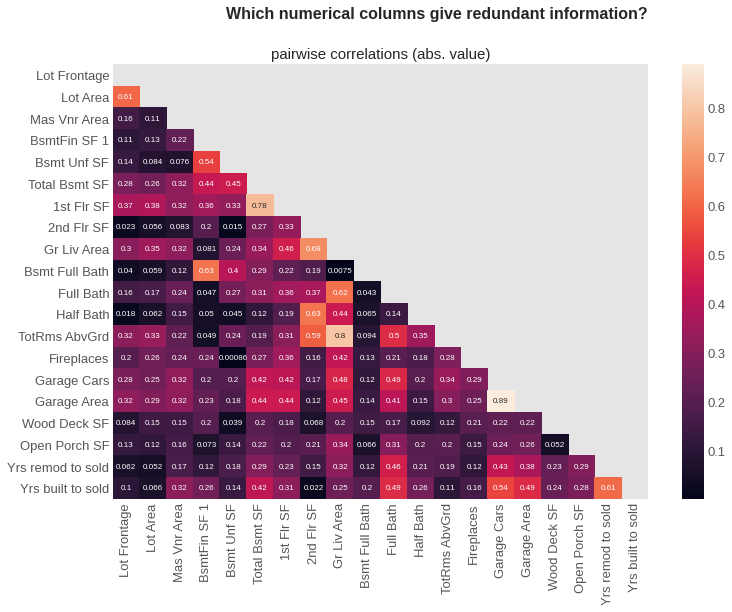

In [22]:
plt.style.use('ggplot')
final_data_pairwise_corr = select_num_features(engin_df, 'SalePrice', .2, .001)

Based on the correlations shown above, we decide to drop from the model the following columns (we keep `TotRms AbvGrd` because it's usually an important quantity):

In [23]:
high_collinearity_cols = ['Total Bsmt SF', 'Bsmt Full Bath', 'Half Bath', 'Garage Area']

final_data = final_data_pairwise_corr.drop(high_collinearity_cols, axis=1)
print(final_data.shape)
final_data.head()

(2655, 89)


,Lot Frontage,Lot Area,Mas Vnr Area,BsmtFin SF 1,Bsmt Unf SF,1st Flr SF,2nd Flr SF,Gr Liv Area,Full Bath,TotRms AbvGrd,...,Garage Type_Attchd,Garage Type_Basment,Garage Type_BuiltIn,Garage Type_CarPort,Garage Type_Detchd,Garage Type_not_present,Garage Finish_RFn,Garage Finish_Unf,Garage Finish_not_present,SalePrice
1,0.584158,0.501750,0.000000,0.238168,0.126168,0.256856,0.000000,0.194598,0.25,0.3,...,1,0,0,0,0,0,0,1,0,105000
2,0.594059,0.630323,0.187500,0.469720,0.189720,0.454753,0.000000,0.344529,0.25,0.4,...,1,0,0,0,0,0,0,1,0,172000
3,0.712871,0.479292,0.000000,0.541985,0.488318,0.811700,0.000000,0.614958,0.50,0.6,...,1,0,0,0,0,0,0,0,0,244000
4,0.524752,0.609080,0.000000,0.402545,0.064019,0.271481,0.394263,0.448407,0.50,0.4,...,1,0,0,0,0,0,0,0,0,189900
5,0.564356,0.421836,0.034722,0.306361,0.151402,0.270567,0.381327,0.439751,0.50,0.5,...,1,0,0,0,0,0,0,0,0,195500


With the parameters and criteria used, the final model will use the following features:

In [24]:
print('\033[1mNumerical\033[0m:',  '\n' + '-'*9)
print(list(final_data.select_dtypes(exclude='uint8').drop('SalePrice', axis=1).columns))
print()
print('\033[1mCategorical\033[0m:' + '\n' + '-'*11)
print(selected_cat_cols)

Numerical: 
---------
['Lot Frontage', 'Lot Area', 'Mas Vnr Area', 'BsmtFin SF 1', 'Bsmt Unf SF', '1st Flr SF', '2nd Flr SF', 'Gr Liv Area', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Wood Deck SF', 'Open Porch SF', 'Yrs remod to sold', 'Yrs built to sold']

Categorical:
-----------
['Garage Type', 'Heating QC', 'Central Air', 'Foundation', 'Fireplace Qu', 'Garage Finish', 'Bsmt Qual', 'Kitchen Qual', 'Overall Qual', 'Exter Qual', 'Neighborhood']


## Train and test univariate and multivariate models

Time to see if our group of selected features can actually predict the house sale prices better than the best performing univariate models.<br/>
The following function will take the dataset, fit it with a linear model and return the RMSE or the average RMSE (according to which validation procedure is chosen).

In [25]:
def train_and_test(data: pd.DataFrame, target='SalePrice', k=9, rs=1) -> float:
    '''
    Train and test a linear regression model on the given dataset.
    
    Parameters:
    -----------
        - data: the cleaned and engineered dataset. All features will be used.
        - target: target feature in the regression problem.
        - k: 0 -> perform holdout validation;
             1 -> perform simple cross-validation;
            >1 -> perform k+1-fold validation.
        - rs: random state for reproducibility.
        
    Return:
    -------
        RMSE or average RMSE of the model.    
    '''
    
    # holdout validation
    if k == 0:
              
        # define train and test sets
        ind = int(len(data) / 2)
        train = data[:ind]
        test = data[ind:]

        # fit a linear regression model on the train set
        lr = LinearRegression()
        X = train.drop(target, axis=1)
        y = train[target]  
        lr.fit(X, y)

        # validate model on the test set
        X_test = test.drop(target, axis=1)
        y_true = test[target]
        y_pred = lr.predict(X_test)
        rmse = mean_squared_error(y_true, y_pred, squared=False)
        
    # simple cross validation    
    elif k == 1:    
        
        # shuffle dataset
        data_shu = data.sample(frac=1, random_state=rs)
        
        # define train and test sets
        ind = int(len(data_shu) / 2)
        fold_one = data_shu[:ind]
        fold_two = data_shu[ind:]
        
        # train on fold_one, test on fold_two; then exchange
        train_test = [(fold_one, fold_two), (fold_two, fold_one)]
        rmses = []
        for train, test in train_test:
            lr = LinearRegression()
            X = train.drop(target, axis=1)
            y = train[target]  
            lr.fit(X, y)
            X_test = test.drop(target, axis=1)
            y_true = test[target]
            y_pred = lr.predict(X_test)
            rmses.append(mean_squared_error(y_true, y_pred, squared=False))
        rmse = np.mean(rmses)
            
    # k+1-fold cross validation
    elif k >= 2:
        lr = LinearRegression()
        kfold = KFold(n_splits=k+1, shuffle=True, random_state=rs)
        rmses = cross_val_score(lr, X=data.drop(target, axis=1), y=data[target], 
                                cv=kfold, scoring='neg_root_mean_squared_error')
        # average RMSE will be returned
        rmse = -np.mean(rmses)         
    
    return round(rmse)

### - Univariate models

Let's fit all the univariate models using the selected numerical features. We'll use a 10-fold cross validation to get the average root mean square error.

In [26]:
results = pd.Series([], dtype='float')

for col in final_data.select_dtypes(exclude='uint8').drop('SalePrice', axis=1).columns:
    results[col] = train_and_test(final_data[[str(col), 'SalePrice']], 'SalePrice', k=9, rs=45)

Results (avg RMSE in USD):

Gr Liv Area          46195.0
Garage Cars          48780.0
Yrs built to sold    51229.0
1st Flr SF           51877.0
Yrs remod to sold    52852.0
Full Bath            53064.0
TotRms AbvGrd        57021.0
Fireplaces           57706.0
Mas Vnr Area         58217.0
Open Porch SF        59628.0
BsmtFin SF 1         59961.0
Lot Area             60584.0
Lot Frontage         60860.0
Wood Deck SF         61318.0
2nd Flr SF           62464.0
Bsmt Unf SF          63297.0
dtype: float64


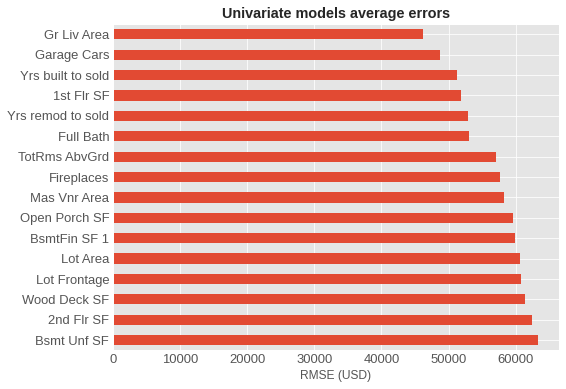

In [27]:
print('\033[1mResults\033[0m (avg RMSE in USD):\n')    
print(results.sort_values())    

# bar plot of rmse results
fig, ax = plt.subplots(figsize=(8,6))
results.sort_values(ascending=False).plot.barh(ax=ax)
ax.set_title('Univariate models average errors', weight='bold')
ax.set_xlabel('RMSE (USD)')
plt.show()

The **best univariate predictors** are the area above the ground, the size of garage in car capacity and how old the house is in years. Their average error in predicting the house prices is of the order of **46000 - 51000 USD**.<br/>
The area above the ground and the house age are very reasonable as good predictors. More surprising, at least a priori, is the size of garage.

Can we do better by combining several features?

## - Multivariate models

**1) Using all selected numerical features**

As a first step, let's use **all the selected numerical features without any categorical**.<br/>
We will use a 10-fold cross validation and fit the model for 100 values of random state, i.e. shuffle the dataset in 100 different ways. This way, we'll have a better idea of performance variations and consistency.

count      100.000000
mean     27186.950000
std         31.935343
min      27111.000000
25%      27166.000000
50%      27189.000000
75%      27208.500000
max      27271.000000
dtype: float64


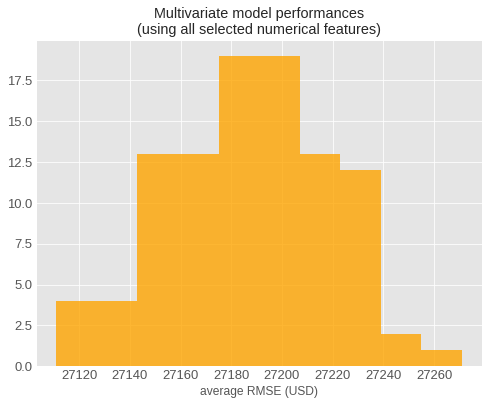

In [33]:
rmses = []
for seed in range(0,100):
    rmses.append(train_and_test(final_data.select_dtypes(exclude='uint8'), 'SalePrice', k=9, rs=seed))

# show results statistcs    
print(pd.Series(rmses).describe())
fig, ax = plt.subplots(figsize=(8, 6))
plt.hist(rmses, color='orange', alpha=.8)
plt.title('Multivariate model performances\n(using all selected numerical features)')
plt.xlabel('average RMSE (USD)')
plt.show()

We clearly see that the model has improved with respect to the univariate case: in fact, we went from a best case RMSE of around **46000 USD** to a much lower **27000 USD**.<br/> 
The performance variations are within a hundred dollars, very consistent. 

**2) All selected numerical features + one categorical**

Next we want to see how the model behaves when we add one categorical feature at a time.

In [29]:
rmses = pd.Series([], dtype='float')
for i, col in enumerate(selected_cat_cols):
    cat_cols = [column for column in final_data.columns if col in column]
    # concat all numerical features with the categorical "col"
    data = pd.concat([final_data.select_dtypes(exclude='uint8'), final_data[cat_cols]], axis=1)
    rmses['num feats + ' + col] = train_and_test(data, k=9)  

In [30]:
print('\033[1mResults\033[0m (avg RMSE in USD):\n')
print(rmses.sort_values())

Results (avg RMSE in USD):

num feats + Overall Qual     21595.0
num feats + Neighborhood     23810.0
num feats + Exter Qual       24695.0
num feats + Kitchen Qual     24766.0
num feats + Bsmt Qual        25114.0
num feats + Fireplace Qu     26404.0
num feats + Foundation       26717.0
num feats + Heating QC       26851.0
num feats + Garage Finish    26949.0
num feats + Garage Type      27153.0
num feats + Central Air      27265.0
dtype: float64


What we see is interesting: some categorical features significantly lower the average error by a few thousand dollars, others hardly have any impact. None of them worsen the model, though.

The categorical features with **highest predictive power** seem to be: 
- **the overall quality** of the house (material and finishing)
- **the neighborhood** where the house is located (as we had insisted intuitively)

On the other hand, the type of garage (meaning garage location with respect to the house) and the presence of air conditioning seem to be much less important in determining the price.

At the moment, our best performing model has an average error of about **21700 USD**.

**3) All selected numerical and categorical features**

As a last step, let's use all the features we have selected in the previous part of the project.

In [31]:
print('\033[1mResults\033[0m (avg RMSE in USD):\n')
for seed in range(5, 10):
    print(train_and_test(final_data, 'SalePrice', k=9, rs=seed))

Results (avg RMSE in USD):

19530.0
19599.0
19620.0
19613.0
19588.0


This is the best performance among all the combinations we've tried: around **19600 USD**.<br/>

## Summary of results and conclusions

We recap the results of the previous section in a dataframe:

In [32]:
recap = pd.DataFrame(columns=['\033[1mModel\033[0m', 'RMSE (USD)', 'Performance improv. (%)'])

recap.loc[0] = ('Best univariate (above groud living area)', 46195, np.nan)
recap.loc[1] = ('Multivariate numerical', 27186, round((46195-27186)/46195 * 100, 1))
recap.loc[2] = ('Multiv. numerical + Overall quality', 21595, round((27186 - 21595)/27186 * 100, 1))
recap.loc[3] = ('All selected features', 19600, round((21595 - 19600)/21595  * 100,1))

print(recap.set_index('\033[1mModel\033[0m'))

                                          RMSE (USD)  Performance improv. (%)
Model                                                                
Best univariate (above groud living area)      46195                      NaN
Multivariate numerical                         27186                     41.1
Multiv. numerical + Overall quality            21595                     20.6
All selected features                          19600                      9.2


Our goal in this project was to build a multivariate model for the prediction of house sale prices in Ames, Iowa, whose performances were significantly better than the univariate models. We obtained this result reducing the error by 41% with a multivariate numerical model, and then by improving this result by including 11 categorical features.

**The best model can predict the house sale price with an average error of 19600 USD**.

We also saw that feature engineering is a crucial step in building a working model: the two new features we defined (house age and years since remodeling) were among those selected as the best numerical predictors.<br/> Carefully reading the docs has proven to be a necessary step, because this gave precise meaning to features and allowed to discover that nan meaning was not trivial for categorical features.
